# Air Passengers

The "Air Passengers" dataset is a classic time series dataset that consists of monthly totals of international airline passengers from 1949 to 1960. Originally collected by Box and Jenkins, it was published in their influential 1970 book "Time Series Analysis: Forecasting and Control" where it was used to demonstrate various time series forecasting techniques. The dataset shows a clear upward trend with strong seasonal patterns (more people traveling during summer months), making it ideal for illustrating seasonal decomposition and forecasting methods.

The dataset has since become a staple in time series analysis education and is frequently used to teach concepts like seasonality, trend identification, and forecasting models such as ARIMA. Its popularity stems from its clear patterns and manageable size (144 observations), making it perfect for demonstrating core time series techniques without overwhelming complexity.

The original model that Box and Jenkins applied to the Air Passengers dataset in their 1970 book "Time Series Analysis: Forecasting and Control" was an ARIMA (Autoregressive Integrated Moving Average) model with seasonal components, specifically a seasonal ARIMA or SARIMA model.

After observing that the variance of the series increased with the level (showing heteroscedasticity), they first applied a logarithmic transformation to stabilize the variance. Then, they identified that the transformed series required both regular and seasonal differencing to achieve stationarity. The final model they specified was an ARIMA(0,1,1)(0,1,1)<sub>12</sub> model, which includes first-order non-seasonal and seasonal moving average terms with both regular and seasonal differencing. This parsimonious model captured both the trend and the strong seasonal pattern in airline passenger numbers remarkably well, demonstrating the power of their Box-Jenkins methodology for time series analysis

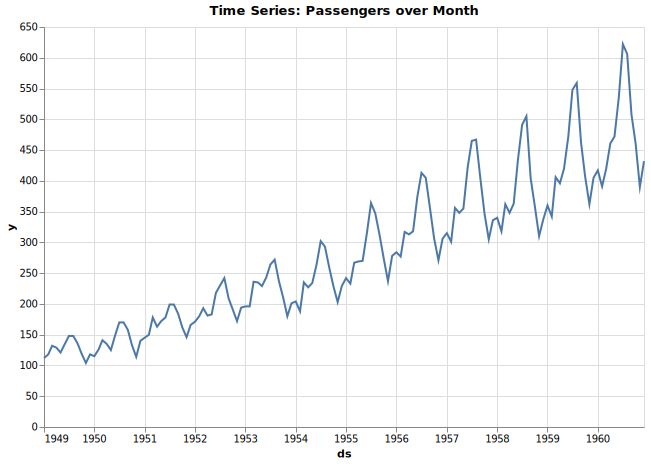

In [1]:
import altair as alt
import pandas as pd

from time_series_analysis import TimeSeriesAnalyzer

# comment the following line to enable chart interactivity
alt.renderers.enable("svg")

url = "https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv"
df = pd.read_csv(url, parse_dates=["ds"])

tsa = TimeSeriesAnalyzer(df, y_name="Passengers", ds_name="Month")
tsa

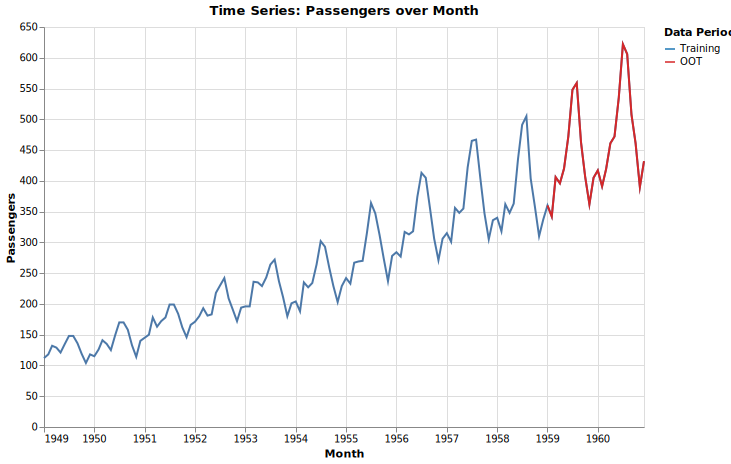

In [2]:
tsa.oot_periods = 24
tsa

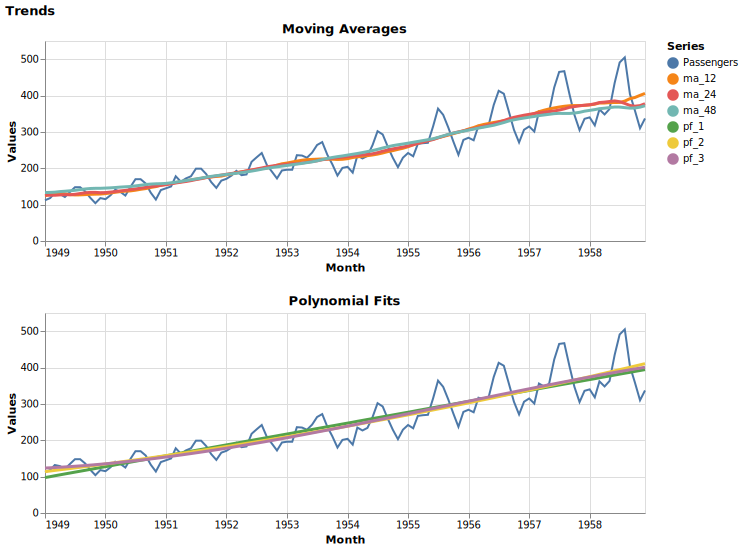

In [3]:
tsa.plot_trends(polyfit_degrees=(1, 2, 3), moving_average_windows=(12, 24, 48))

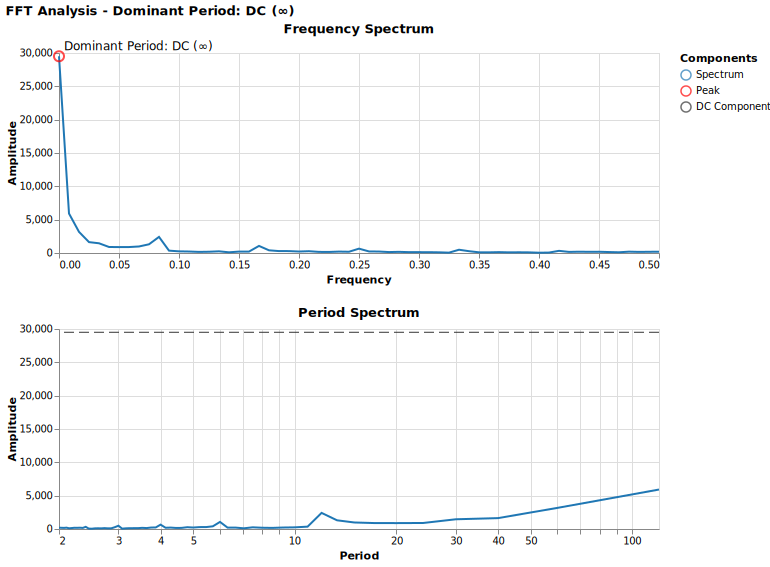

,frequency,period,amplitude
0,0.0,0.0,29509.0


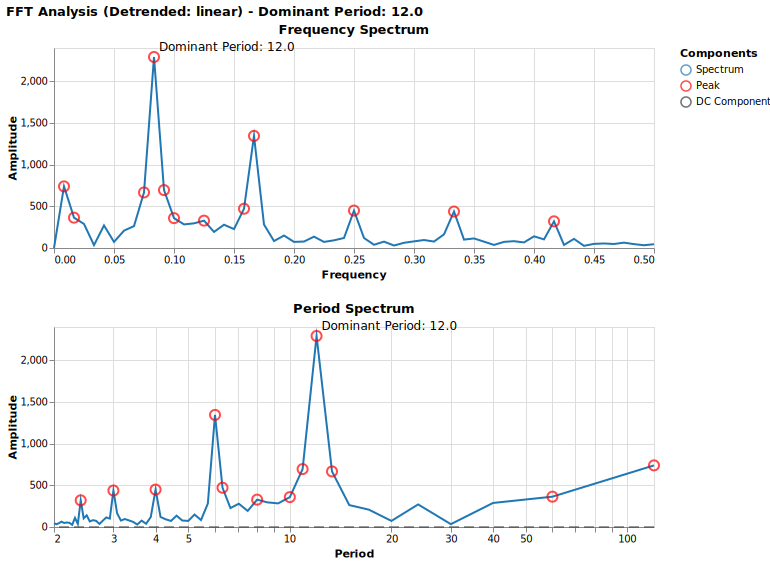

,frequency,period,amplitude
1,0.008333,120.000000,739.356213
2,0.016667,60.000000,363.960659
9,0.075000,13.333333,666.667051
10,0.083333,12.000000,2292.195390
11,0.091667,10.909091,694.952533
12,0.100000,10.000000,358.536428
15,0.125000,8.000000,328.285142
19,0.158333,6.315789,471.185928
20,0.166667,6.000000,1345.133841
30,0.250000,4.000000,448.973600


In [4]:
detrends = None, "linear"
thresholds = 0.5, 0.13

for detrend, threshold in zip(detrends, thresholds):
    display(tsa.plot_fft_analysis(threshold=threshold, detrend=detrend))
    display(tsa.list_peaks(threshold=threshold, detrend=detrend))

Signals at 12, 6, 4, 3, 

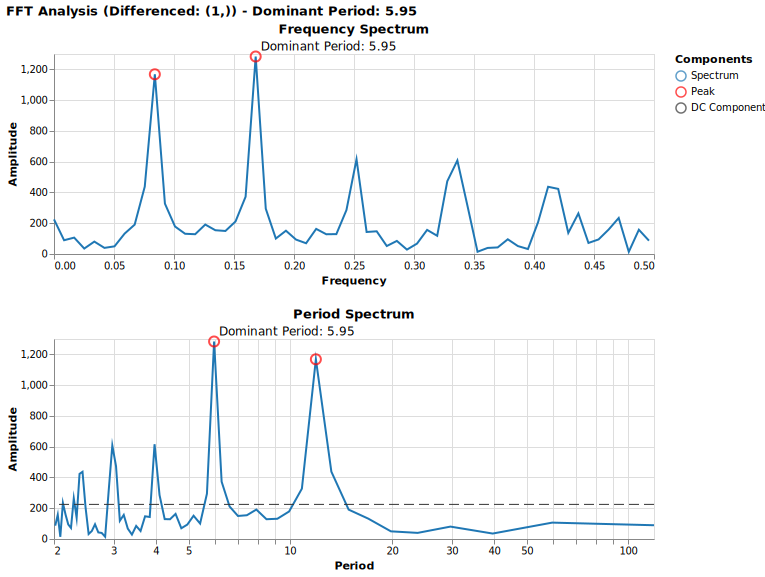

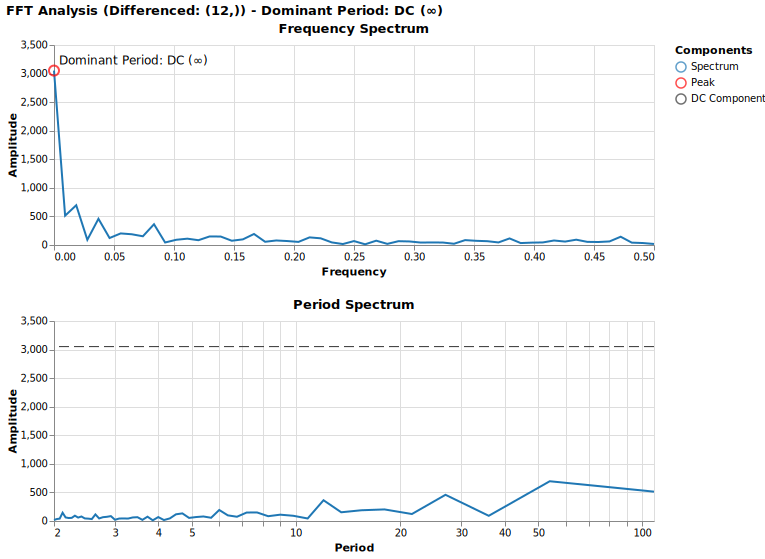

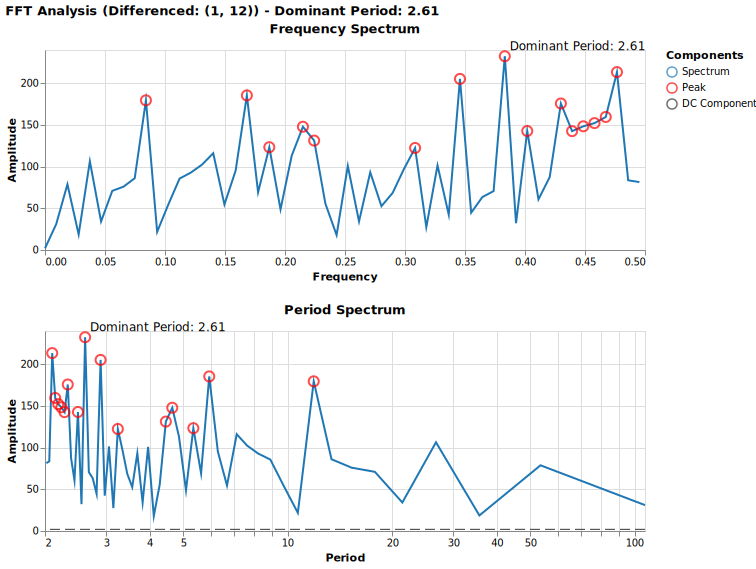

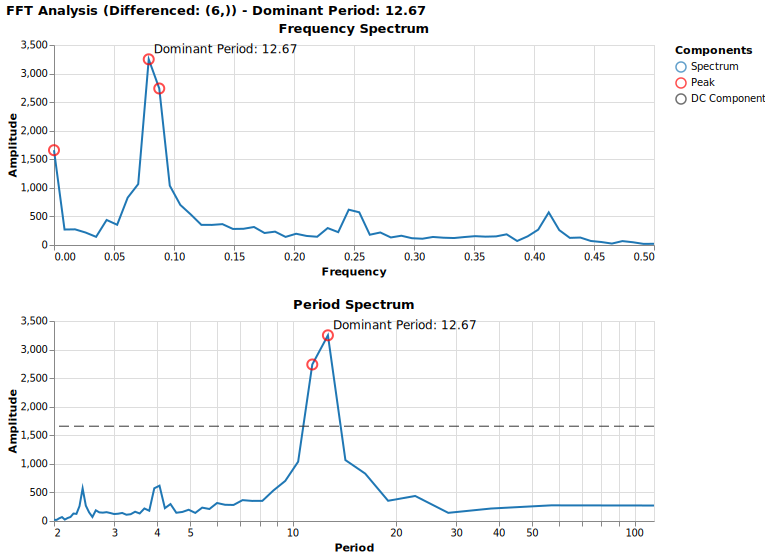

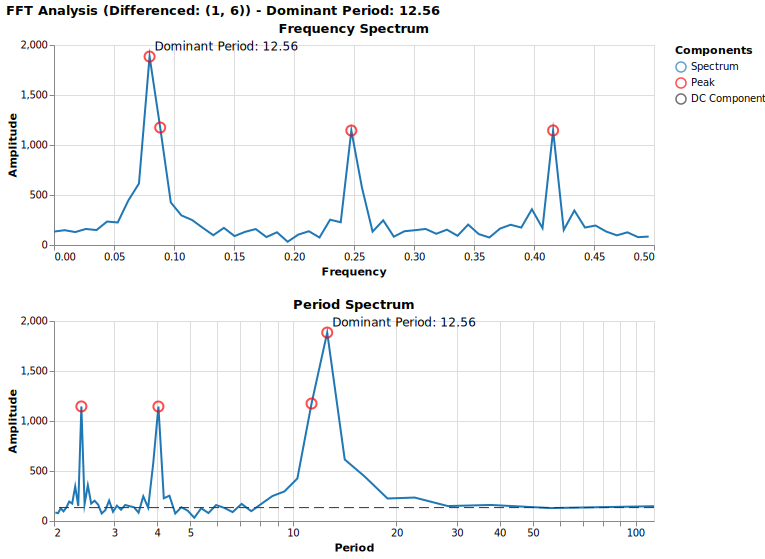

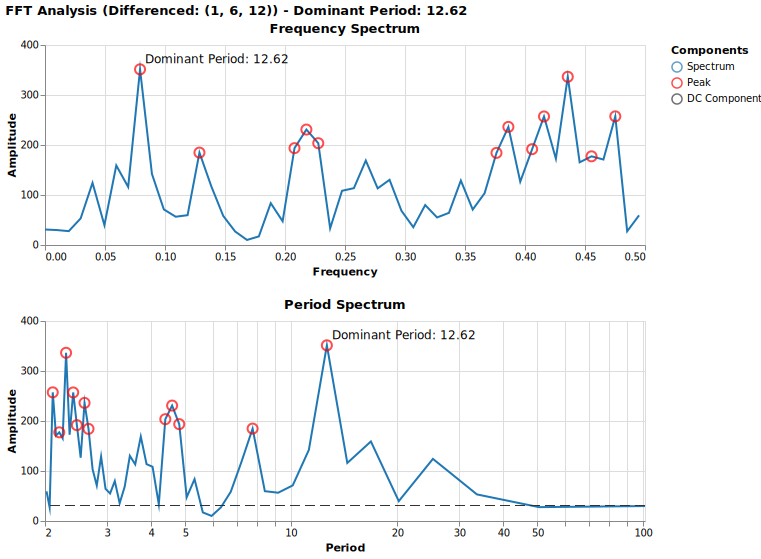

In [5]:
differences = (1,), (12,), (1, 12), (6,), (1, 6), (1, 6, 12)

for diffs in differences:
    display(tsa.plot_fft_analysis(detrend=diffs))


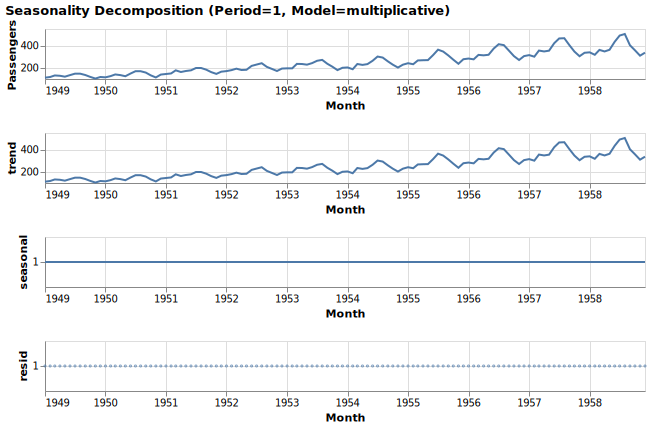

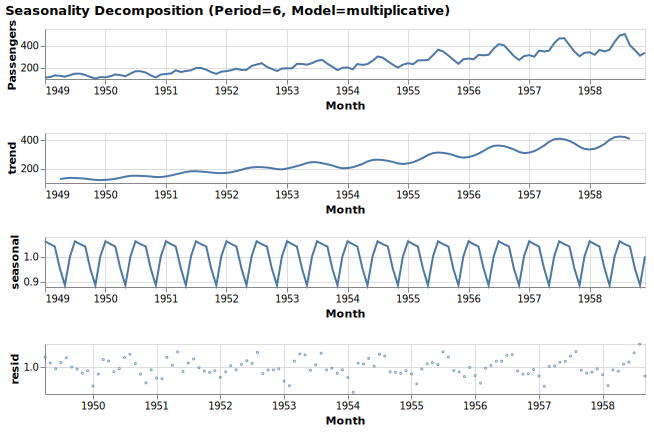

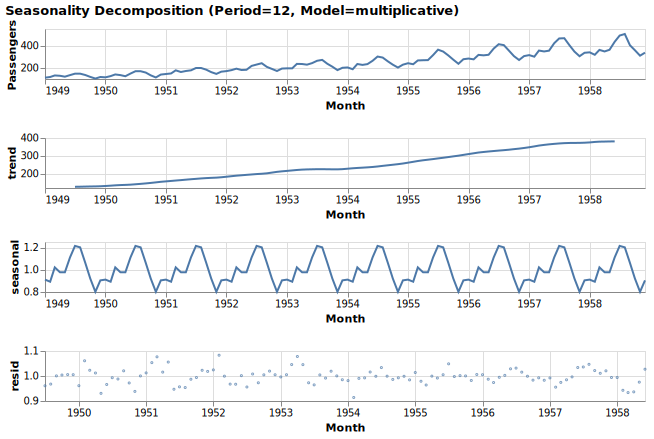

In [6]:
periods = 1, 6, 12

for period in periods:
    display(tsa.plot_seasonal_decomposition(period=period, model="multiplicative"))

In [7]:
differences = (1,), (12,), (1, 12), (6,), (1, 6), (1, 6, 12)

for diffs in (tuple(), *differences):
    print(f"Differences: {diffs}")
    display(tsa.adf_test(*diffs))

Differences: ()


Test Statistic         -0.773461
p-value                 0.826794
Critical Value (1%)    -3.493602
Critical Value (5%)    -2.889217
Critical Value (10%)   -2.581533
dtype: float64

Differences: (1,)


Test Statistic         -2.164143
p-value                 0.219516
Critical Value (1%)    -3.493602
Critical Value (5%)    -2.889217
Critical Value (10%)   -2.581533
dtype: float64

Differences: (12,)


Test Statistic         -3.001403
p-value                 0.034764
Critical Value (1%)    -3.494220
Critical Value (5%)    -2.889485
Critical Value (10%)   -2.581676
dtype: float64

Differences: (1, 12)


Test Statistic         -1.305194e+01
p-value                 2.133051e-24
Critical Value (1%)    -3.493602e+00
Critical Value (5%)    -2.889217e+00
Critical Value (10%)   -2.581533e+00
dtype: float64

Differences: (6,)


Test Statistic         -2.514837
p-value                 0.111906
Critical Value (1%)    -3.493602
Critical Value (5%)    -2.889217
Critical Value (10%)   -2.581533
dtype: float64

Differences: (1, 6)


Test Statistic         -7.063546e+00
p-value                 5.149653e-10
Critical Value (1%)    -3.495493e+00
Critical Value (5%)    -2.890037e+00
Critical Value (10%)   -2.581971e+00
dtype: float64

Differences: (1, 6, 12)


Test Statistic         -3.262298
p-value                 0.016650
Critical Value (1%)    -3.507853
Critical Value (5%)    -2.895382
Critical Value (10%)   -2.584824
dtype: float64

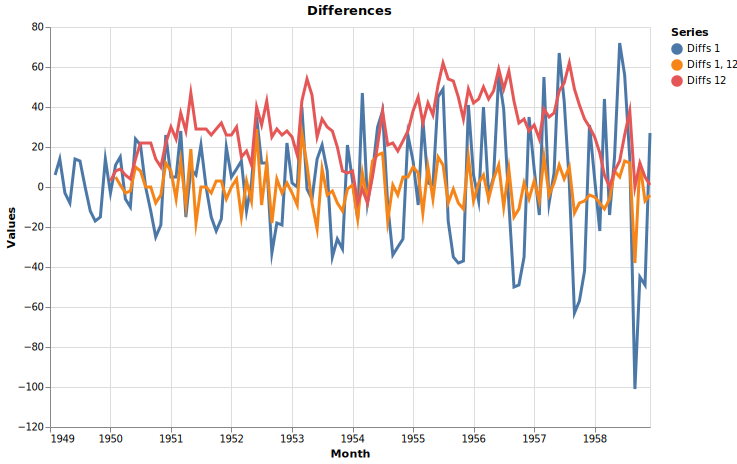

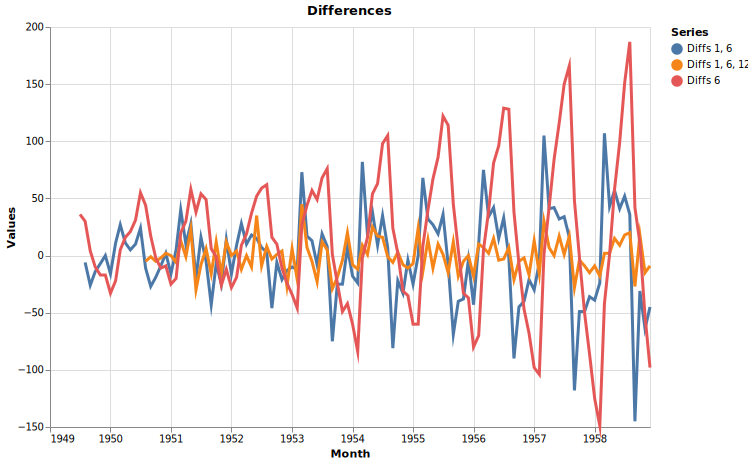

In [8]:
differences = (1,), (12,), (1, 12), (6,), (1, 6), (1, 6, 12)

display(tsa.plot_diffs(*differences[:3]))
display(tsa.plot_diffs(*differences[3:]))

In [9]:
from typing import Protocol

import altair as alt
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import ARIMA


def create_arima_model(
    order: tuple[int, int, int] = (0, 0, 0),
    seasonal_order: tuple[int, int, int] = (0, 0, 0),
    season_length: int = 1,
    alias: str | None = None,
) -> ARIMA:
    return ARIMA(
        order=order,
        season_length=season_length,
        seasonal_order=seasonal_order,
        alias=alias or f"Arima {order} {seasonal_order} {season_length}",
    )


def log_transform(df: pd.DataFrame, cols: str | list[str] = "y") -> pd.DataFrame:
    if isinstance(cols, str):
        cols = [cols]

    return df.assign(**{c: np.log(df[c]) for c in cols})


def exp_transform(df: pd.DataFrame, cols: str | list[str] = "y") -> pd.DataFrame:
    if isinstance(cols, str):
        cols = [cols]

    return df.assign(**{c: np.exp(df[c]) for c in cols})


class Transformer(Protocol):
    @staticmethod
    def transform(df: pd.DataFrame, cols: str | list[str] = "y") -> pd.DataFrame: ...
    @staticmethod
    def inverse(df: pd.DataFrame, cols: str | list[str] = "y") -> pd.DataFrame: ...


class Log:
    @staticmethod
    def transform(df: pd.DataFrame, cols: str | list[str] = "y") -> pd.DataFrame:
        if isinstance(cols, str):
            cols = [cols]
        return df.assign(**{c: np.log(df[c]) for c in cols})

    @staticmethod
    def inverse(df: pd.DataFrame, cols: str | list[str] = "y") -> pd.DataFrame:
        if isinstance(cols, str):
            cols = [cols]

        return df.assign(**{c: np.exp(df[c]) for c in cols})


def train_predict(
    train: pd.DataFrame,
    valid: pd.DataFrame,
    models: list,
    transformers: list[Transformer] | None = None,
    h: int | None = None,
) -> tuple[pd.DataFrame, StatsForecast]:
    if h is None:
        h = len(valid)

    if transformers:
        for t in transformers:
            train = train.pipe(t.transform)

    sf = StatsForecast(models=models, freq="MS")
    sf.fit(train)
    preds = sf.predict(h)

    if transformers:
        cols = [c for c in preds.columns if c not in ("ds", "unique_id")]
        for t in transformers:
            preds = preds.pipe(t.inverse, cols)

    return preds.merge(valid), sf


def plot_preds(df: pd.DataFrame) -> alt.Chart:
    return (
        alt.Chart(
            df.rename(columns={"y": "Actuals"})
            .drop("unique_id", axis=1)
            .melt(id_vars="ds", var_name="series", value_name="value")
        )
        .mark_line()
        .encode(x="ds", y=alt.Y("value").scale(zero=False), color="series")
        .properties(height=600)
    )


def compute_metrics(df: pd.DataFrame) -> None:
    for col in [c for c in df.columns if c not in ("ds", "y", "unique_id")]:
        true = df["y"]
        pred = df[col]

        mse = (pred - true).pow(2).mean()
        msle = (np.log1p(pred) - np.log1p(true)).pow(2).mean()

        print("model:", col)
        print("rmse", round(np.sqrt(mse), 4))
        print("rmsle", round(np.sqrt(msle), 4))
        print("")

/home/sorin/time-series-analysis/.venv/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/sorin/time-series-analysis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model: Arima (0, 1, 1) (0, 1, 1) 12
rmse 35.8176
rmsle 0.0823



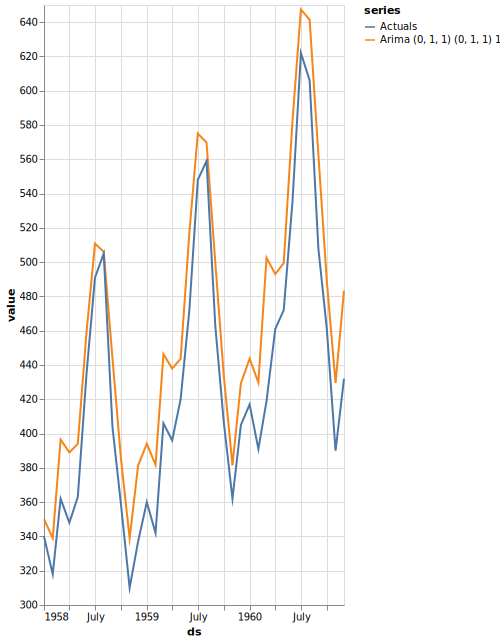

In [10]:
models = [
    create_arima_model((0, 1, 1), (0, 1, 1), 12),
]

tsa.oot_periods = 36

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

log_preds, log_sf = train_predict(train, valid, models, [Log], h)

compute_metrics(log_preds)
plot_preds(log_preds)

model: Arima (0, 1, 1) (0, 1, 1) 12
rmse 42.345
rmsle 0.0935



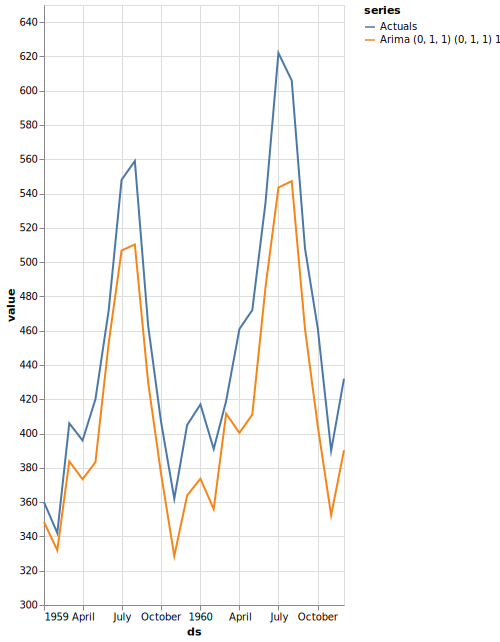

In [11]:
models = [
    create_arima_model((0, 1, 1), (0, 1, 1), 12),
]

tsa.oot_periods = 24

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

log_preds, log_sf = train_predict(train, valid, models, [Log], h)

compute_metrics(log_preds)
plot_preds(log_preds)

model: Arima (0, 1, 1) (0, 1, 1) 12
rmse 18.5853
rmsle 0.0402



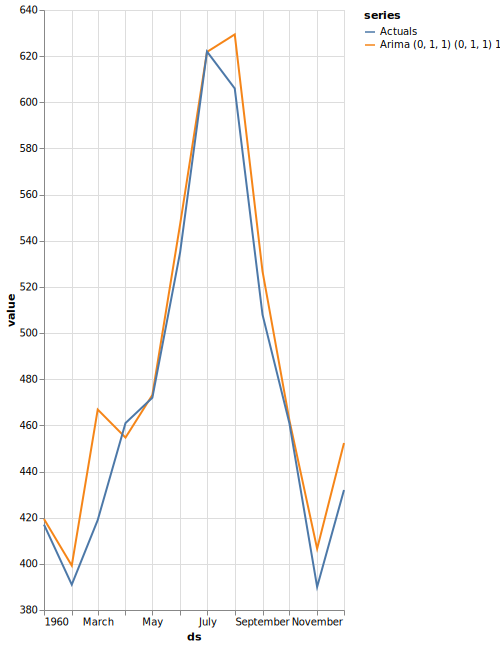

In [12]:
models = [
    create_arima_model((0, 1, 1), (0, 1, 1), 12),
]

tsa.oot_periods = 12

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

log_preds, log_sf = train_predict(train, valid, models, [Log], h)

compute_metrics(log_preds)
plot_preds(log_preds)

model: Arima (3, 1, 6) (6, 1, 0) 12
rmse 28.4149
rmsle 0.0654



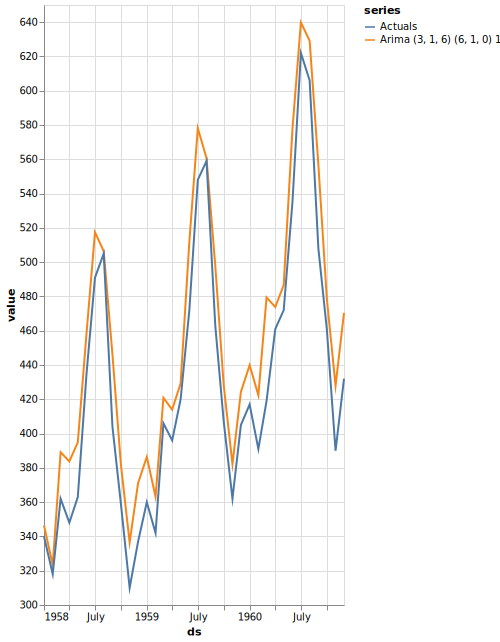

In [13]:
models = [
    create_arima_model((3, 1, 6), (6, 1, 0), 12),
]

tsa.oot_periods = 36

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

preds, sf = train_predict(train, valid, models, [], h)
compute_metrics(preds)
plot_preds(preds)

model: Arima (3, 1, 6) (6, 1, 0) 12
rmse 14.2861
rmsle 0.0318



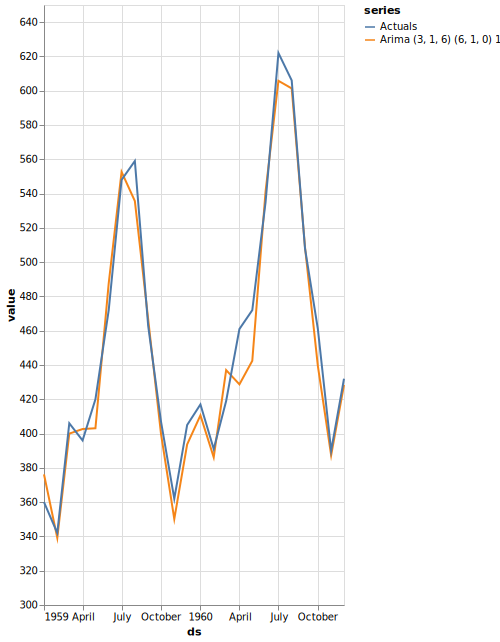

In [14]:
models = [
    create_arima_model((3, 1, 6), (6, 1, 0), 12),
]

tsa.oot_periods = 24

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

preds, sf = train_predict(train, valid, models, [], h)
compute_metrics(preds)
plot_preds(preds)

model: Arima (3, 1, 6) (6, 1, 0) 12
rmse 38.7454
rmsle 0.0814



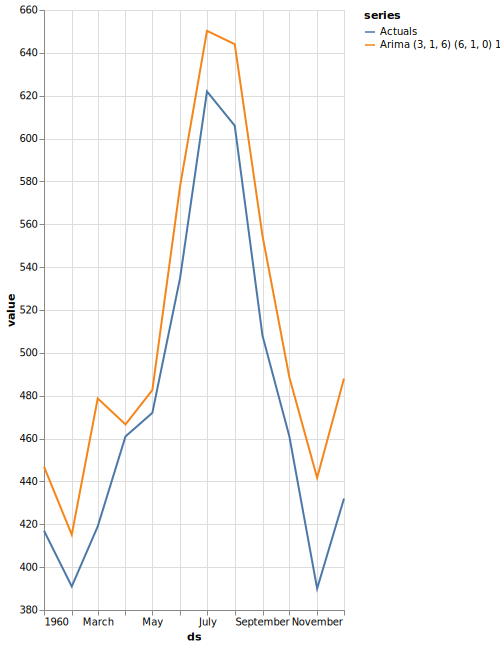

In [15]:
models = [
    create_arima_model((3, 1, 6), (6, 1, 0), 12),
]

tsa.oot_periods = 12

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

preds, sf = train_predict(train, valid, models, [], h)
compute_metrics(preds)
plot_preds(preds)

model: Arima (3, 1, 6) (1, 1, 0) 12
rmse 17.1329
rmsle 0.0369



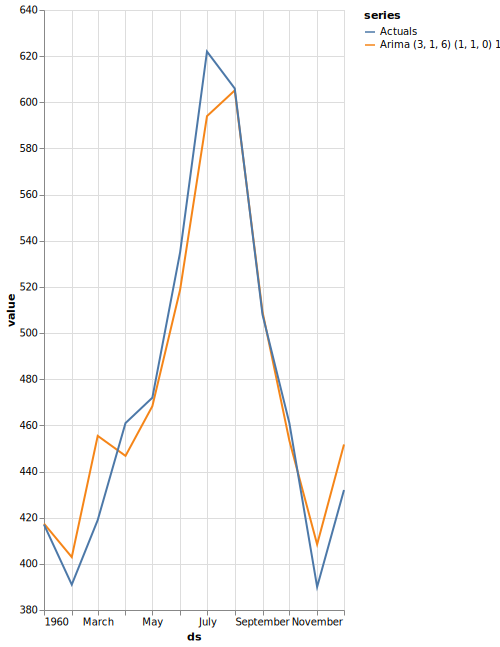

In [16]:
models = [
    create_arima_model((3, 1, 6), (1, 1, 0), 12),
]

tsa.oot_periods = 12

train = tsa.train_data
valid = tsa.oot_data
h = tsa.oot_periods

preds, sf = train_predict(train, valid, models, [], h)
compute_metrics(preds)
plot_preds(preds)